## WSI Ćwiczenie nr.6 - Algorytm Q-learning
### Maciej Łodziński

#### Cel ćwiczenia:
Celem ćwiczenia jest implementacja algorytmu Q-learning oraz stworzenie agenta rozwiązującego problem `TAXI` z biblioteki `gym` i zbadanie wpływu poszczególnych hiperparametrów na działanie tego algorytmu.

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from random import uniform
from statistics import mean

In [2]:
env = gym.make("Taxi-v3").env

In [3]:
class Agent:
    def __init__(self, _env, _learn_rate, _discount, _exploration):
        self.env = _env
        self.learn_rate = _learn_rate
        self.discount = _discount
        self.exploration = _exploration
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])
        self.rewards = []

    def q_learning(self, epochs):
        for i in range(epochs):
            sum_rewards = 0
            state = self.env.reset()
            end = False

            while not end:
                random_value = uniform(0, 1)
                if (random_value < self.exploration):
                    action = self.env.action_space.sample() #exploration
                else:
                    action = np.argmax(self.q_table[state]) #exploitation

                next_state, reward, end, info = self.env.step(action)
                curr_q = self.q_table[state, action]
                next_max_q = np.max(self.q_table[next_state])
                new_q =  curr_q + self.learn_rate * (reward + self.discount * next_max_q - curr_q)
                self.q_table[state, action] = new_q
                state = next_state
                sum_rewards += reward
            if i % int(epochs/100) == 0:
                self.rewards.append(sum_rewards)

    def make_trip(self, max_trips, is_visual=False):
        state = self.env.reset()
        end = False
        trip_length = 0

        while not end and trip_length < max_trips:
            action = np.argmax(self.q_table[state])
            next_state, reward, end, info = self.env.step(action)
            state = next_state
            trip_length += 1
            if is_visual: self.env.render()
        return trip_length

    def average_trips(self, num_trips, max_trips):
        lengths = []
        for _ in range(num_trips):
            length = self.make_trip(max_trips)
            lengths.append(length)
        return mean(lengths)

#### Ogólna funkcja do przeprowadzania eksperymentów
Poniższa funkcja zwraca średnią długość przebytej drogi przy różnych tablicach Q otrzymanych z tych samych parametrów 

In [4]:
def test_param(iterations, num_trips, max_trips, discount, learn_rate, exploration, epochs):    
    result = 0
    for _ in range(iterations):
        agent = Agent(env, learn_rate, discount, exploration)
        agent.q_learning(epochs)
        result += agent.average_trips(num_trips, max_trips)
    
    result /= iterations
    return result

#### Dostosowanie parametru `discount` oraz zbadanie jego wpływu 
`Discount` określa jak bardzo brane pod uwagę mają być nagrody, które agent może otrzymać w przyszłości względem tych które otrzymuje w obecnym kroku. Im większa wartość parametru, tym przyszłe nagrody mają większą wagę. Z kolei w miarę zmniejszania tego parametru przyszłe nagrody jakie agent może otrzymać mają mniejszy wpływ, za to nagrody otrzymywane w danym kroku będą bardziej znaczące.  
  
Optymalną wartością w tym przypadku wydaje się być `discount = 0.9`. Ta wartość jest całkiem stała w obliczu przeprowadzania następnych eksperymentów, mimo elementu losowego w algorytmie.

In [5]:
def test_discount(iterations, num_trips, max_trips):
    discount = [0.5, 0.6, 0.7, 0.8, 0.9]
    learn_rate = 0.3
    exploration = 0.1
    epochs = 10000
    
    num_tests = len(discount)
    results = np.zeros(num_tests)
    for i in range(num_tests):
        test_result = test_param(iterations, num_trips, max_trips, discount[i], learn_rate, exploration, epochs)
        results[i] = test_result
  
    results = np.around(results, 2)
    best_param = discount[np.argmin(results)]
    info = f'{results} -> best discount = {best_param}'
    print(info)
    
test_discount(15, 10, 30)

[13.07 13.17 13.01 12.67 12.97] -> best discount = 0.8


#### Dostosowanie parametru `learn_rate` oraz zbadanie jego wpływu
`Learn_rate` określa jak szybko algorytm będzie zmieniał wartości w tablicy Q tj. jak ważne są nowo zdobyte informacje o środowisku względem tych które już posiada. Im większa wartość parametru, tym tablica Q będzie się szybciej zmieniać i na odwrót. Podobnie jak przy poprzednich projektach, zwiększenie jego wartości skutkuje szybszym uczeniem się agenta, i tym samym osiągnięciem satysfakcjonującego wyniku w mniejszej liczbie iteracji, lecz zbyt duża wartość parametru spowoduje, że agent będzie miał problemy ze znalezieniem rozwiązania.  
  
Optymalną wartością w tym przypadku wydaje się być `learn_rate = 0.1`, lecz zmienia się ona nieznacznie przy prowadzeniu kolejnych eksperymentów, gdyż mają one w sobie element losowy.

In [6]:
def test_learn_rate(iterations, num_trips, max_trips):
    discount = 0.9
    learn_rate = [0.01, 0.03, 0.05, 0.1]
    exploration = 0.1
    epochs = 10000
    
    num_tests = len(learn_rate)
    results = np.zeros(num_tests)
    for i in range(num_tests):
        test_result = test_param(iterations, num_trips, max_trips, discount, learn_rate[i], exploration, epochs)
        results[i] = test_result
  
    results = np.around(results, 2)
    best_param = learn_rate[np.argmin(results)]
    info = f'{results} -> best learn_rate = {best_param}'
    print(info)
    
test_learn_rate(15, 10, 30)

[20.38 13.57 12.93 12.77] -> best learn_rate = 0.1


#### Dostosowanie parametru `exploration` oraz zbadanie jego wpływu 
`Exploration` określa prawdopodobieństwo z jakim ma być wybrana losowa akcja spośród wszystkich dostępnych względem wyboru najlepszej akcji wynikającej z tablicy Q. Im większa wartość parametru, tym agent bardziej eksploruje ( wybiera akcję losowo i tym samym poznaje środowsko), natomiast mała wartość będzie oznaczać eksploatację - podążanie względem strategii zapisanej w tablicy Q.  
  
Optymalną wartością w tym przypadku wydaje się być `exploration = 0.01`. Mała wartość tego parametru ma sens, gdyż chcemy eksplorować tylko raz na jakiś czas, ale przeważnie wybierać jednak najlepszą akcję z tablicy Q.

In [7]:
def test_exploration(iterations, num_trips, max_trips):
    discount = 0.9
    learn_rate = 0.1
    exploration = [0.001, 0.002 , 0.005, 0.01]
    epochs = 10000
    
    num_tests = len(exploration)
    results = np.zeros(num_tests)
    for i in range(num_tests):
        test_result = test_param(iterations, num_trips, max_trips, discount, learn_rate, exploration[i], epochs)
        results[i] = test_result
  
    results = np.around(results, 2)
    best_param = exploration[np.argmin(results)]
    info = f'{results} -> best exploration = {best_param}'
    print(info)
    
test_exploration(15, 10, 30)

[13.14 13.04 13.29 13.21] -> best exploration = 0.002


#### Ostateczny test z dobranymi parametrami
`learn_rate` = 0.1  
`discount` = 0.9  
`exploration` = 0.01

In [15]:
def final_test(epochs, max_trips):
    agent = Agent(_env=env, _learn_rate=0.2, _discount=0.9, _exploration=0.01)
    agent.q_learning(epochs)
    trip_length = agent.make_trip(max_trips, is_visual=True)
    
    if trip_length >= max_trips:
        print("\nPath not found!")
    else:
        print(f'\ntrip lenght = {trip_length}')
    
final_test(epochs=10000, max_trips=30)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | :_:G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : | :_: |
| : : : : |
| | : | : |
|Y| 

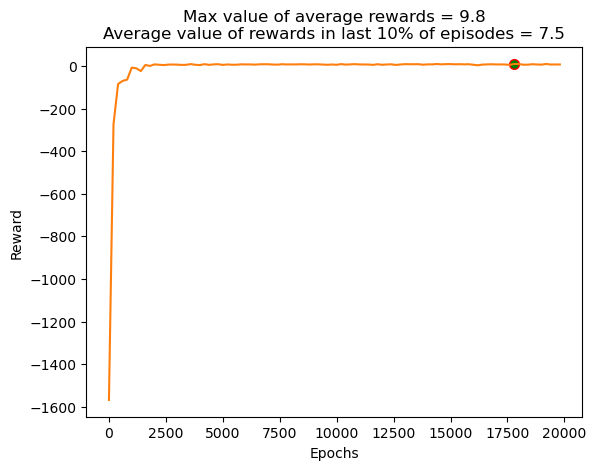

In [18]:
def column_average(list_of_lists):
    column_average = [sum(sub_list) / len(sub_list) for sub_list in zip(*list_of_lists)]
    return column_average

def average_list(table, start, end):
    sliced_table = table[start:end]
    avg = sum(sliced_table) / len(sliced_table)
    return avg

def test_rewards(epochs, max_trips, iterations):
    all_rewards = []
    for i in range(iterations):
        agent = Agent(_env=env, _learn_rate=0.05, _discount=0.9, _exploration=0.01)
        agent.q_learning(epochs)
        all_rewards.append(agent.rewards)
    avg_rewards = column_average(all_rewards)
    return avg_rewards
    
def test_plot(epochs, max_trips, iterations):
    linear_split = [*range(1, epochs+1, int(epochs/100))]
    avg_reward = test_rewards(epochs, max_trips, iterations)
    
    avg_list = round(average_list(avg_reward, 90, 100), 1)
    y = max(avg_reward)
    x = linear_split[avg_reward.index(y)]
    plt.plot(x, y, marker="o", markersize=7, markeredgecolor="red", markerfacecolor="green")
    plt.plot(linear_split, avg_reward)
    plt.xlabel("Epochs")
    plt.ylabel("Reward")
    info_max = f'Max value of average rewards = {y}\n'
    info_avg = f'Average value of rewards in last 10% of episodes = {avg_list}'
    plt.title(info_max + info_avg)
    
test_plot(20000, 30, 10)

### Wnioski:
Po dobraniu odpowiednich parametrów i przeprowadzenia eksperymentu można stwierdzić że algorytm Q learning świetnie sobie radzi z poznawaniem i nauką nieznanego wcześniej środowska. Po nauczeniu agenta, przejeżdża on teraz trasę w najkrótszym możliwym czasie.